PCA+LDA

In [11]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torchvision import datasets, transforms

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
import bokeh
import bokeh.plotting
from bokeh.layouts import column, row
from bokeh.models import HoverTool,WheelZoomTool, PanTool, ResetTool
bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
def data_processed():
    '''
    Used to read & normalize processed test and train data
    '''
    data_train = pd.read_csv("data/2022-02-07_LOANS_TRAIN.csv")
    data_test = pd.read_csv("data/2022-02-07_LOANS_TEST.csv")
    y_train = data_train['loan_status']
    data_train.drop('loan_status', 1, inplace=True)
    data_train.drop('id', 1, inplace=True)
    data_test.drop('id', 1, inplace=True)
    
    scaler = StandardScaler()
    scaler.fit(data_train)
    normal_data_train = scaler.transform(data_train)
    normal_data_test = scaler.transform(data_test)
    
    return normal_data_train, normal_data_test, y_train

def to_submission(ids, y_test_predicted_probability):
    y_test=pd.DataFrame(y_test_predicted_probability,columns=['loan_status'], index=ids)
    y_test.index.name = 'id'
    y_test.to_csv('data/submission.csv')
    return

In [20]:
X_train, X_test, y_train = data_processed()

print(f"""
X_train shape: {X_train.shape}
y_train shape: {y_train.shape}
""")

/var/folders/h7/dxctt03x2vjdfbhcmgymr3400000gn/T/ipykernel_15367/2318960770.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_train.drop('loan_status', 1, inplace=True)
/var/folders/h7/dxctt03x2vjdfbhcmgymr3400000gn/T/ipykernel_15367/2318960770.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_train.drop('id', 1, inplace=True)
/var/folders/h7/dxctt03x2vjdfbhcmgymr3400000gn/T/ipykernel_15367/2318960770.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_test.drop('id', 1, inplace=True)



X_train shape: (197250, 92)
y_train shape: (197250,)



In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42, shuffle=True)

print(f"""
X_train shape: {X_train.shape}
y_train shape: {y_train.shape}
X_val shape: {X_val.shape}
y_val shape: {y_val.shape}
""")


X_train shape: (132157, 92)
y_train shape: (132157,)
X_val shape: (65093, 92)
y_val shape: (65093,)



In [22]:
fraction = 1
rus = RandomUnderSampler(random_state=0, sampling_strategy=fraction)
X_train, y_train = rus.fit_resample(X_train, y_train)

print(f"""
X_train shape: {X_train.shape}
y_train shape: {y_train.shape}
""")


X_train shape: (40480, 92)
y_train shape: (40480,)



In [10]:
pca = PCA(n_components = 0.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_val = pca.transform(X_val)

In [12]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_prob = lda.predict_proba(X_val)

In [15]:
roc_auc_score(y_val, y_pred_prob[:, 1])

0.6685531850688915

In [18]:
lda = LinearDiscriminantAnalysis(solver='lsqr')
lda.fit(X_train, y_train)
y_pred_prob = lda.predict_proba(X_val)
roc_auc_score(y_val, y_pred_prob[:, 1])

0.6685531850688915

In [19]:
lda = LinearDiscriminantAnalysis(solver='eigen')
lda.fit(X_train, y_train)
y_pred_prob = lda.predict_proba(X_val)
roc_auc_score(y_val, y_pred_prob[:, 1])

0.6685531850688915

lda without pca

In [23]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_prob = lda.predict_proba(X_val)
roc_auc_score(y_val, y_pred_prob[:, 1])

0.6831789379765323

In [27]:
lda = LinearDiscriminantAnalysis(solver='lsqr')
lda.fit(X_train, y_train)
y_pred_prob = lda.predict_proba(X_val)
roc_auc_score(y_val, y_pred_prob[:, 1])

0.6831656466456222

In [28]:
prediction = lda.predict(X_val)
prediction

array([1, 0, 0, ..., 0, 0, 0])

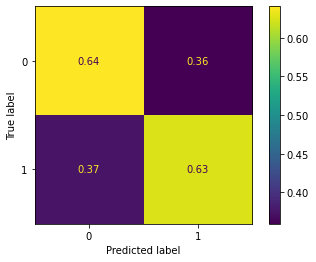

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf = confusion_matrix(y_val, prediction, normalize='true')
disp = ConfusionMatrixDisplay(conf)
disp.plot()